[1D] epoch=   0 loss=1.288280
[1D] epoch= 200 loss=0.060166
[1D] epoch= 400 loss=0.005206
[1D] epoch= 600 loss=0.002675
[1D] epoch= 800 loss=0.002558
[1D] learned a≈1.8033, b≈0.1948 | true a=1.8000, b=0.2000


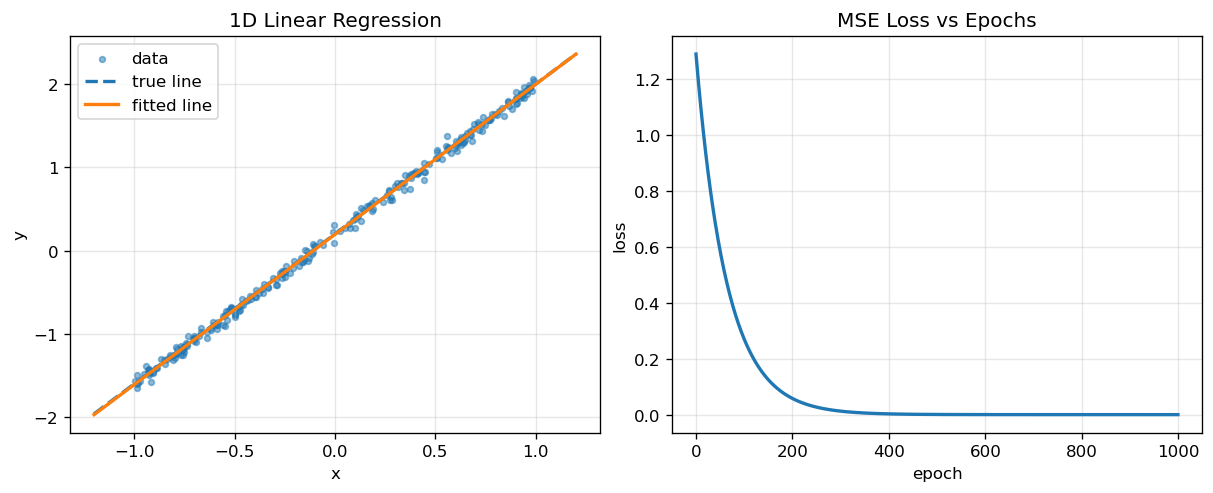

In [1]:
# Linear Regression in JAX

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120 # set default figure DPI for better resolution

# ==============================================================================
# Toy Example A — Linear regression (explicit), with plots
# ==============================================================================

# ---------- data ----------
key = jax.random.key(0)  # random key
N = 256                  # total number of samples (batch size B = N)
a_true, b_true = 1.8, 0.2  # true parameters for linear regression

key, sub = jax.random.split(key)  # split key into two new keys (dont reuse same key because reusing keys causes correlation in random numbers)

# We use shapes (N, 1) instead of (N,) to match the usual "design matrix" convention:
#   • batch axis B = N  (rows = examples)
#   • feature dimension d_in = 1   (one scalar x per example)
#   • output dimension d_out = 1   (one scalar y per example)
x = jax.random.uniform(
    key, (N, 1), minval=-1.0, maxval=1.0
)  # x ∈ R^{N×1} = (N,1) array of inputs U(min=-1, max=1)

noise = 0.05 * jax.random.normal(
    sub, (N, 1)
)  # Gaussian noise ∈ R^{N×1} = 0.05 * [(N,1) array of samples from N(0,1)]

y = a_true * x + b_true + noise  # y ∈ R^{N×1} = (N,1) array of noisy scalar targets (d_out = 1)


# ---------- model ----------
# Linear regression: f(x; θ) = a * x + b = ŷ
# Parameters: θ = (a, b) ∈ R^2  -> stored as a 1D array of shape (2,)
# Full-batch GD: use all N samples each step (B = N), with x, y, ŷ ∈ R^{N×1}
def f(theta, x):
    # theta: shape (2,)  (a,b)
    # x:     shape (N,1) (batch B=N, d_in=1)
    a, b = theta
    return a * x + b      # ŷ: shape (N,1) (batch B=N, d_out=1)


# ---------- loss ----------
# Mean Squared Error over the full batch:
#   L(θ) = (1/N) * Σ_{i=1..N} ( f_θ(x_i) - y_i )^2
def mse(theta, x, y):
    yhat = f(theta, x)            # (N,1)
    return jnp.mean((yhat - y) ** 2)


# ---------- initialize theta ----------
def init_params_1d(key=None, scale=0.01):
    """Return theta = [a, b]."""
    if key is None:
        # default: zero initialization (perfectly fine for linear regression)
        return jnp.array([0.0, 0.0])
    # small random initialization: scale * N(0,1) in R^2
    return scale * jax.random.normal(key, (2,))


# ---------- optimizer (SGD) ----------
@jax.jit  # JIT-compile the SGD step function for speed
def sgd_step(theta, x, y, lr=1e-2):
    # note that the batch size B = N, since we use full-batch gradient descent
    # here rather than subdivide (so each step is an "epoch")
    loss, grads = jax.value_and_grad(mse)(theta, x, y)
    # grads has same shape as theta, i.e. (2,)
    theta = theta - lr * grads  # SGD update with learning rate lr
    return theta, loss          # returns updated theta and previous loss


# ---------- train ----------
theta = init_params_1d(jax.random.key(1))
loss_hist = []
for epoch in range(1000):  # 1000 epochs of full-batch gradient descent
    theta, loss = sgd_step(theta, x, y, lr=1e-2)
    loss_hist.append(float(loss))
    if epoch % 200 == 0:
        print(f"[1D] epoch={epoch:4d} loss={float(loss):.6f}")

a_hat, b_hat = map(float, theta)
print(f"[1D] learned a≈{a_hat:.4f}, b≈{b_hat:.4f} | true a={a_true:.4f}, b={b_true:.4f}")

# ---------- plots ----------
# For plotting, we again use shape (N_plot, 1) to stay consistent with
# "batch of feature-vectors with d_in = 1".
x_plot = jnp.linspace(-1.2, 1.2, 200)[:, None]  # (200,1)
y_fit  = f(theta, x_plot)                       # (200,1)
y_true = a_true * x_plot + b_true               # (200,1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axs[0].scatter(x, y, s=12, alpha=0.5, label="data")
axs[0].plot(x_plot, y_true, '--', lw=2, label="true line")
axs[0].plot(x_plot, y_fit,  '-', lw=2, label="fitted line")
axs[0].set_title("1D Linear Regression")
axs[0].set_xlabel("x"); axs[0].set_ylabel("y")
axs[0].legend(); axs[0].grid(alpha=0.3)

axs[1].plot(loss_hist, lw=2)
axs[1].set_title("MSE Loss vs Epochs")
axs[1].set_xlabel("epoch"); axs[1].set_ylabel("loss")
axs[1].grid(alpha=0.3)

plt.show()

[Torch 1D] epoch=   0 loss=1.068280
[Torch 1D] epoch= 200 loss=0.081666
[Torch 1D] epoch= 400 loss=0.008797
[Torch 1D] epoch= 600 loss=0.003376
[Torch 1D] epoch= 800 loss=0.002972
[Torch 1D] learned a≈1.7955, b≈0.2047 | true a=1.8000, b=0.2000


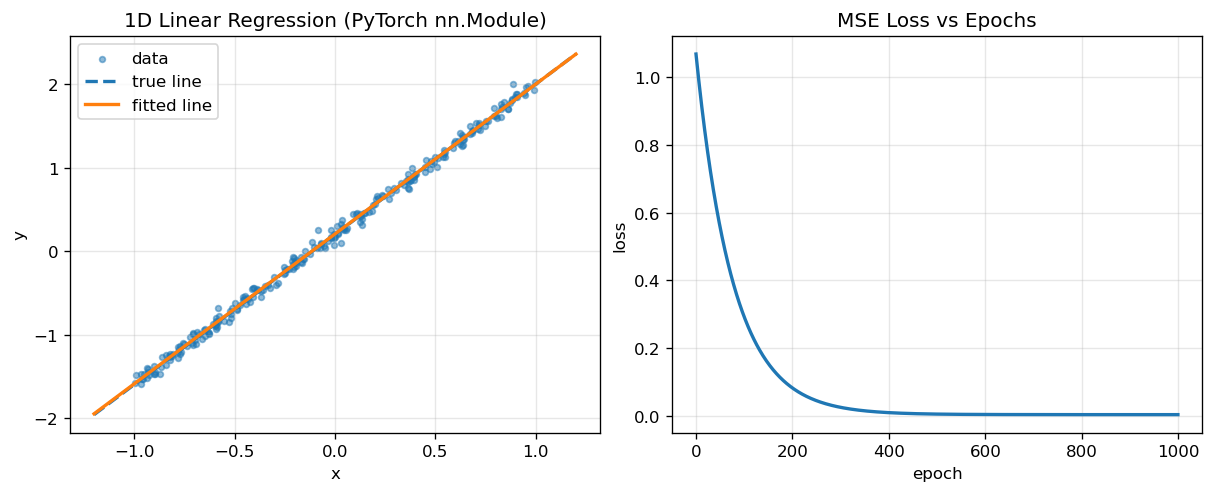

In [ ]:

# What is nn.Module?
# ----------------------------------------------------------------------------------
# • nn.Module is the base class for *all* learnable components in PyTorch:
#     - Layers: nn.Linear, nn.Conv2d, nn.LSTM, ...
#     - Whole models: your custom networks
#     - Containers: nn.Sequential, nn.ModuleList, etc.
#
# • Conceptually, an nn.Module bundles:
#
#   1) Parameters
#      - Learnable tensors (requires_grad=True) registered as "parameters".
#      - Stored in a tree: module → submodules → their parameters.
#      - Discovered by .parameters(), which you pass to optimizers:
#            optimizer = torch.optim.SGD(model.parameters(), lr=...)
#
#   2) Submodules
#      - Other nn.Module instances stored as attributes:
#            self.linear = nn.Linear(...); self.conv = nn.Conv2d(...)
#      - Automatically registered so that:
#            list(model.children()), list(model.modules())
#        see them, and model.state_dict() includes their weights.
#
#   3) A forward function
#      - You define:
#            def forward(self, x):
#                return F(x; θ)
#      - Calling model(x) actually calls model.__call__(x), which:
#            * runs pre/post hooks,
#            * calls forward(x),
#            * integrates with autograd.
#
# • Why subclass nn.Module instead of using plain functions?
#     - Keeps parameters + sub-layers organized as a single object.
#     - Easy device moves: model.to("cuda"), model.to("cpu"), etc.
#     - Easy save/load: model.state_dict(), model.load_state_dict(...).
#     - Optimizers integrate cleanly via model.parameters().
#
# • Minimal pattern:
#
#       class MyModel(nn.Module):
#           def __init__(self):
#               super().__init__()            # IMPORTANT: init nn.Module internals
#               self.layer = nn.Linear(10, 5) # registered submodule + parameters
#
#           def forward(self, x):
#               return self.layer(x)
#
#       model = MyModel()     # calls MyModel.__init__ → super().__init__ → nn.Module.__init__
#       y = model(x)          # model.__call__(x) → forward(x)
#       loss = loss_fn(y, target)
#       loss.backward()       # fills .grad for all leaf parameters
#       optimizer.step()      # updates all tensors in model.parameters()
#
# • Why super().__init__() matters:
#       class MyModel(nn.Module):
#           def __init__(self):
#               super().__init__()  # calls nn.Module.__init__(self)
#               ...
#   nn.Module.__init__ sets up the machinery to:
#       - register parameters and buffers,
#       - track submodules,
#       - make .to(), .cuda(), .cpu(), .parameters(), state_dict(), etc. work.
#   If you skip super().__init__(), your parameters may not be registered and
#   optimizers / device moves / state_dict() can silently misbehave.
#
# • Quick sanity check:
#
#       model = MyModel()
#       for name, param in model.named_parameters():
#           print(name, param.shape, param.requires_grad)
#
#   Typical output:
#       layer.weight  torch.Size([5, 10])  True
#       layer.bias    torch.Size([5])      True
#
#   This confirms:
#       - nn.Linear created weight & bias with requires_grad=True.
#       - Because we called super().__init__(), they are properly registered as
#         parameters of MyModel and will be updated by the optimizer.
#


In [ ]:
# ==============================================================================
# Toy Example A — 1D Regression with a Tiny MLP (PyTorch, nn.Module + F.relu)
# ==============================================================================
#
# Goal:
#   • Keep the same synthetic 1D regression data: y ≈ a_true * x + b_true + noise
#   • Replace pure linear model with a 2-layer MLP:
#         x → Linear(1→H) → ReLU → Linear(H→1)
#   • Use torch.nn.functional for the activation (F.relu).

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# ---------- data ----------
torch.manual_seed(0)  # reproducible randomness per run

N = 256                                # total number of samples
a_true, b_true = 1.8, 0.2              # true parameters for the underlying linear relationship

# x ∈ R^{N×1} from U(-1,1)
x = -1.0 + 2.0 * torch.rand(N, 1)      # torch.rand ~ U(0,1) → scale+shift to [-1,1]

# Gaussian noise ∈ R^{N×1} = 0.05 * N(0,1)
noise = 0.05 * torch.randn(N, 1)

# y ∈ R^{N×1} = a_true * x + b_true + noise
y = a_true * x + b_true + noise


# ---------- model ----------
# Tiny MLP:
#   f(x; θ) = Linear2( ReLU( Linear1(x) ) )
# where:
#   • Linear1: R^1 → R^H   (hidden layer)
#   • Linear2: R^H → R^1   (output)
#
# We use nn.Module for the layers, and torch.nn.functional (F.relu) for the activation.

class MLPRegression1D(nn.Module):
    def __init__(self, hidden_dim: int = 8):
        super().__init__()

        # Two linear layers (parameters live inside these modules):
        self.fc1 = nn.Linear(in_features=1, out_features=hidden_dim, bias=True)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=1, bias=True)

        # Optional: simple init to make things predictable/benign.
        with torch.no_grad():
            # Small random weights; biases zero
            nn.init.normal_(self.fc1.weight, mean=0.0, std=0.1)
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.normal_(self.fc2.weight, mean=0.0, std=0.1)
            nn.init.constant_(self.fc2.bias, 0.0)

    def forward(self, x):
        """
        Forward pass:
          x: shape (N,1)
          return: ŷ ∈ R^{N×1}
        """
        h = self.fc1(x)      # affine: x → W1 x + b1
        h = F.relu(h)        # nonlinearity from torch.nn.functional
        yhat = self.fc2(h)   # affine: h → W2 h + b2
        return yhat


# Instantiate the model
model = MLPRegression1D(hidden_dim=16)

# ---------- loss ----------
# Mean Squared Error over full batch:
criterion = nn.MSELoss(reduction="mean")


# ---------- optimizer (SGD) ----------
optimizer = optim.SGD(model.parameters(), lr=5e-3)  # slightly smaller lr than pure linear

# ---------- train ----------
num_epochs = 1000
loss_hist = []

for epoch in range(num_epochs):
    model.train()                    # good habit, matters for dropout/BN (no effect here)

    # Forward pass
    yhat = model(x)                  # (N,1)

    # Loss
    loss = criterion(yhat, y)

    # Backprop + update
    optimizer.zero_grad()            # clear old grads
    loss.backward()                  # fill .grad on all leaf parameters
    optimizer.step()                 # SGD step

    loss_hist.append(loss.item())

    if epoch % 200 == 0:
        print(f"[Torch 1D MLP] epoch={epoch:4d}  loss={loss.item():.6f}")

# Extract something “effective” to compare to the true linear rule:
#   Around x≈0, the MLP behaves approximately linearly; but since we added ReLU + hidden units,
#   there's no single (a_hat, b_hat) that fully characterizes it. We'll just print the final loss.
print(f"[Torch 1D MLP] final loss ≈ {loss_hist[-1]:.6f}")

# ---------- plots ----------
# x_plot: dense grid for plotting model prediction vs true underlying line
x_plot = torch.linspace(-1.2, 1.2, steps=200).unsqueeze(1)  # shape (200,1)

with torch.no_grad():
    y_fit  = model(x_plot)                  # MLP fit
    y_true = a_true * x_plot + b_true       # true underlying line (no noise)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Left: data and curves
axs[0].scatter(x.numpy(), y.numpy(), s=12, alpha=0.5, label="data")
axs[0].plot(x_plot.numpy(), y_true.numpy(), '--', lw=2, label="true line")
axs[0].plot(x_plot.numpy(), y_fit.numpy(),  '-', lw=2, label="MLP fit")
axs[0].set_title("1D Regression with Tiny MLP (PyTorch)")
axs[0].set_xlabel("x"); axs[0].set_ylabel("y")
axs[0].legend(); axs[0].grid(alpha=0.3)

# Right: loss vs epochs
axs[1].plot(loss_hist, lw=2)
axs[1].set_title("MSE Loss vs Epochs")
axs[1].set_xlabel("epoch"); axs[1].set_ylabel("loss")
axs[1].grid(alpha=0.3)

plt.show()


In [ ]:
# 1.2 (single-layer NN for parameter inference using ADAMW in PyTorch)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('mps' if torch.backends.mps.is_available() else "cpu") 
# convert data to PyTorch tensors
times_t = torch.as_tensor(times, dtype=torch.float32)
x_data_t = torch.as_tensor(x_data, dtype=torch.float32)

class ParameterInference(nn.Module): # pass 

    def __init__(self, theta_init):
        super().__init__() 
        theta_init = torch.as_tensor(theta_init, dtype=torch.float32)
        self.theta = nn.Parameter(theta_init)

    def forward(self, t):
        a, beta, omega, delta = self.theta
        return a * torch.exp(-beta*t) * torch.cos(omega*t - delta)

theta_init = initial_parameters()
net = ParameterInference(theta_init)

criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-2, weight_decay=1e-2) # decoupled L2 regularization
adw_losses = []

for epoch in range(num_epochs+1):

    net.train()
    
    yhat = net(times_t)              
    loss = criterion(yhat, x_data_t)     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()              

    if epoch % (num_epochs // 5) == 0:
        print(f"At epoch = {epoch}, loss = {loss.item()}")
    adw_losses.append(loss.item())

with torch.no_grad():
     # θ̂ = (a, β, ω, δ) as NumPy
    theta_hat = net.theta.detach().cpu().numpy()
    # fitted curve on same time grid
    x_fit_np = net(times_t).detach().cpu().numpy()
    t_plot = times_t.detach().cpu().numpy()

a_hat, beta_hat, omega_hat, delta_hat = theta_hat

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

axs[0].scatter(t_plot, x_data, s=12, alpha=0.5, label="data")
axs[0].plot(t_plot, x_fit_np, '--', color='C1', lw=2, label="fitted curve")
axs[0].set_title("Data vs Fitted Curve (PyTorch + AdamW)")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x(t)")
axs[0].legend()
axs[0].grid(alpha=0.3)

axs[1].plot(epochs, adw_losses, lw=2)
axs[1].set_title("MSE Loss vs Epochs (AdamW)")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("loss")
axs[1].grid(alpha=0.3)

plt.show()

print(f"After training (Torch/AdamW), the predicted theta is " f"a = {a_hat:.3f}, β = {beta_hat:.3f}, ω = {omega_hat:.3f}, δ = {delta_hat:.3f}")
'Note that the loss asymptotes to ~ 8e-3 much quicker than SGD due to AdamW optimizer.'